In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold , StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv(r"C:\Users\ghpu\JupyterNotebook\datasets\healthcare\train.csv")
train['is_train'] = 1
test = pd.read_csv(r"C:\Users\ghpu\JupyterNotebook\datasets\healthcare\test.csv")
test['is_train'] = 0
sample = pd.read_csv(r"C:\Users\ghpu\JupyterNotebook\datasets\healthcare\sample_submission.csv")

In [4]:
merge = pd.concat([train,test]).reset_index(drop=True)

city_code_max = max(merge["City_Code_Patient"])
bed_grade_max = max(merge["Bed Grade"])

merge["City_Code_Patient"] = merge["City_Code_Patient"].fillna(city_code_max + 1)
merge["Bed Grade"] = merge["Bed Grade"].fillna(bed_grade_max + 1)

merge["City_Code_Patient"] = merge["City_Code_Patient"].apply(lambda x: int(x))
merge["Bed Grade"] = merge["Bed Grade"].apply(lambda x: int(x))

uniques = pd.DataFrame(merge.drop(['Stay','is_train'],axis=1).nunique())
cat_columns = uniques[uniques[0] < 50].index.values.tolist()
cat_columns.remove("Available Extra Rooms in Hospital")

merge = merge[~merge['Available Extra Rooms in Hospital'].isin([14,20,24])]

for i in ['Hospital_type_code', "Hospital_region_code", "Department", "Ward_Type", 'Ward_Facility_Code', "Type of Admission", "Severity of Illness", "Age"]:
  merge[i] = pd.factorize(merge[i])[0]

#########
from tqdm import tqdm_notebook as tqdm

useful_combs = [['Ward_Type','Visitors with Patient'],
                ['Ward_Type','Bed Grade'],
                ['Bed Grade', 'Severity of Illness'],
                ['Hospital_code', 'City_Code_Patient'],
                ['City_Code_Hospital', 'City_Code_Patient'],
                ['Bed Grade', 'Type of Admission'],
                ['Severity of Illness', 'Age'],
                ['Hospital_region_code', 'Ward_Type'],
                ['Type of Admission', 'Visitors with Patient'],
                ['Ward_Type', 'Ward_Facility_Code'],
                ['Hospital_code', 'Visitors with Patient'],
                ['Type of Admission', 'Age'],
                ['Ward_Type', 'Type of Admission'],
                ['Severity of Illness', 'Visitors with Patient'],
                ['City_Code_Hospital', 'Ward_Type'],
                ['Department', 'Ward_Type'],
                ['Visitors with Patient', 'Age'],
                ['Hospital_code', 'Type of Admission'],
                ['Bed Grade', 'Age'],
                ['Department', 'Severity of Illness'],
                ['Department', 'Visitors with Patient'],
                ['City_Code_Hospital', 'Visitors with Patient'],
                ['Hospital_region_code', 'Age'],
                ['Bed Grade', 'Visitors with Patient'],
                ['Hospital_code', 'Department'],
                ['Hospital_code', 'Severity of Illness'],
                ['Hospital_region_code', 'Bed Grade']]

for comb in tqdm(useful_combs):
  one,two = comb
  name = f'{one}__{two}'
  # merge[name] = merge.apply(lambda x:str(x[one]) +"_"+str(x[two]),axis=1)
  merge[name] = merge[one].astype(str) + "_" + merge[two].astype(str)

  merge[name] = pd.factorize(merge[name])[0]  
  if len(np.unique(merge[name])) < 50:
    cat_columns.append(name)

# for f in cat_columns:
#   merge[f] = merge[f].map(merge[f].value_counts(normalize = True))
  
one,two = 'Ward_Type','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","std":f"{one}_{two}_std"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'patientid','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Age','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Hospital_code','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Hospital_type_code','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Type of Admission','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'City_Code_Patient','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'City_Code_Hospital','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = ['Hospital_code','Ward_Type'],'Visitors with Patient'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")




one,two = 'Hospital_code','Available Extra Rooms in Hospital'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'City_Code_Hospital','Available Extra Rooms in Hospital'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Ward_Type','Available Extra Rooms in Hospital'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Department','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'patientid','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'City_Code_Patient','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Ward_Type__Visitors with Patient','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")





one,two = 'Hospital_code','Admission_Deposit'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'patientid','Admission_Deposit'
m = merge.groupby([one])[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = ['Visitors with Patient'],'Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = ['Hospital_code','Department'],'Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Age','Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Department','Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Ward_Type__Visitors with Patient','Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")



c = ['Hospital_code','Hospital_type_code',
     'City_Code_Hospital',"Hospital_region_code",'Department',
     'Ward_Type','Type of Admission','Age']

from itertools import combinations
for comb in tqdm(combinations(c,2)):
  one,two = comb
  m = merge.groupby([one])[two].agg(['nunique','count'])
  m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
  merge = merge.merge(m,on=[one],how="left")





# one,two = 'City_Code_Hospital','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'City_Code_Hospital','Hospital_code'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Hospital_code','Ward_Type'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Hospital_type_code','Hospital_code'
# m = merge.groupby([one])[two].agg(['count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Age','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Hospital_code','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'City_Code_Patient','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")


#########
train = merge[merge.is_train == 1]
test = merge[merge.is_train == 0]
train.drop(["is_train",'case_id'],axis=1,inplace=True)
test.drop(["is_train",'Stay'],axis=1,inplace=True)

merge

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,...,Department_Type of Admission_nunique,Department_Type of Admission_count,Department_Age_nunique,Department_Age_count,Ward_Type_Type of Admission_nunique,Ward_Type_Type of Admission_count,Ward_Type_Age_nunique,Ward_Type_Age_count,Type of Admission_Age_nunique,Type of Admission_Age_count
0,1,8,0,3,0,3,0,0,0,2,...,3,41031,10,41031,3,182936,10,182936,10,168362
1,2,2,0,5,0,2,0,1,0,2,...,3,41031,10,41031,3,111165,10,111165,10,217669
2,3,10,1,1,1,2,1,1,1,2,...,3,42357,10,42357,3,111165,10,111165,10,217669
3,4,26,2,2,2,2,0,0,2,2,...,3,41031,10,41031,3,182936,10,182936,10,217669
4,5,26,2,2,2,2,0,1,2,2,...,3,41031,10,41031,3,111165,10,111165,10,217669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455486,455491,11,2,2,2,4,1,2,2,3,...,3,42357,10,42357,3,152046,10,152046,10,168362
455487,455492,25,1,1,1,2,0,0,1,4,...,3,41031,10,41031,3,182936,10,182936,10,168362
455488,455493,30,0,3,0,2,1,0,4,4,...,3,42357,10,42357,3,182936,10,182936,10,69460
455489,455494,5,3,1,1,2,1,0,1,4,...,3,42357,10,42357,3,182936,10,182936,10,217669


In [5]:
# uniques = 
# pd.DataFrame(merge.drop(['Stay','is_train'],axis=1).nunique())
test.isna().sum()
# merge.columns
# pd.DataFrame(merge.drop(['Stay','is_train'],axis=1).nunique())
# cat_columns

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
                                    ..
Ward_Type_Type of Admission_count    0
Ward_Type_Age_nunique                0
Ward_Type_Age_count                  0
Type of Admission_Age_nunique        0
Type of Admission_Age_count          0
Length: 186, dtype: int64

In [6]:
one,two = 'Age','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum","min":f"{one}_{two}_min","max":f"{one}_{two}_max"})
m
# # sns.jointplot(x=one,y=two,data=train,kind="kde")
# # plt.show()
# # sns.jointplot(x=one,y=two,data=test,kind="kde")
# one,two = 'Hospital_code','Age'
# m = pd.DataFrame(merge.groupby(one)[two].value_counts()).unstack().reset_index()
# m.columns = [f"{one}_" + '_'.join([str(j) for j in i]).strip("_") + "_count" for i in m.columns]
# # merge = merge.merge(m,on=[one],how="left")
# m

,Age_Visitors with Patient_mean,Age_Visitors with Patient_sum,Age_Visitors with Patient_max,std
Age,,,,
0,3.546191,246478,32,1.932125
1,3.356335,170287,32,1.867150
2,3.073712,277925,24,1.619884
3,3.323529,304083,24,1.706601
4,3.393861,38147,32,1.884166
5,3.486034,169484,29,1.894957
6,3.028808,177367,24,1.590233
7,3.107494,74179,24,1.559545
8,3.407221,31142,24,1.946329


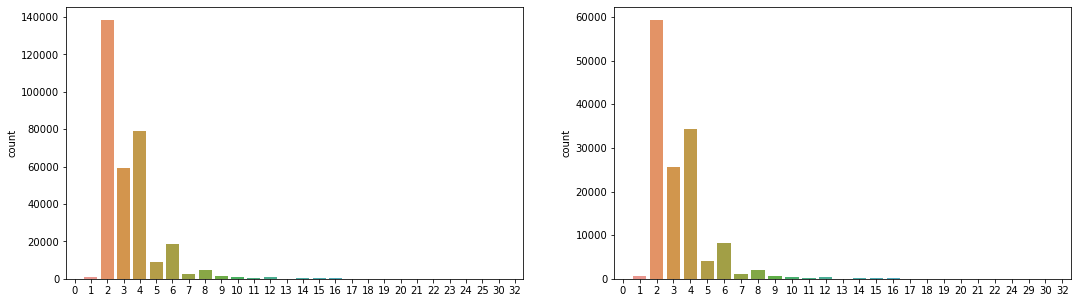

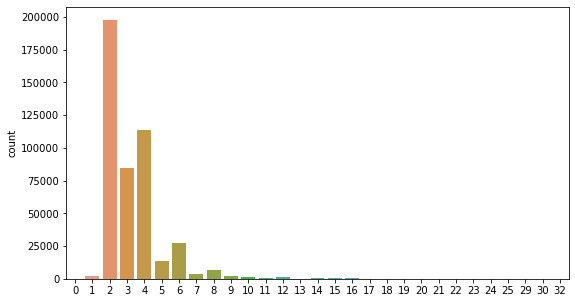

In [7]:
# col = "Available Extra Rooms in Hospital"
# train mein 14 20 24 extra hain ( Done )

# col = "patientid"

# col = "Visitors with Patient"
# train mein 25 hai lekin test mein 29

col = "Visitors with Patient"
fig,ax = plt.subplots(1,2,figsize=(18,5))

sns.countplot(sorted(train[col]),ax=ax[0])
sns.countplot(sorted(test[col]),ax=ax[1])
plt.show()

plt.figure(figsize=(9,5))
sns.countplot(sorted(merge[col]))

In [8]:
X = train.drop(["Stay"],axis=1)
Y = train[['Stay']]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_ = encoder.fit_transform(Y)
Y['Stay'] = Y_

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0224,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    # "boosting_type":"Plain"
}


def work(X,Y):
  final_preds = []
  best_score = 0
  scores = []

  folds = KFold(n_splits=5,shuffle=True,random_state=1250)

  for train_idx , test_idx in folds.split(X,Y):
    train_set = (X.iloc[train_idx],Y.iloc[train_idx])
    test_set = (X.iloc[test_idx],Y.iloc[test_idx])

    model = CatBoostClassifier(**params)
    model.fit(*train_set,
              cat_features = cat_columns,
              eval_set=[test_set],early_stopping_rounds=500,verbose=200)

    score = accuracy_score(test_set[1].values,model.predict(test_set[0]))
    print(score)
    scores.append(score)

    if score > best_score:
      best_score = score
      best_model = model

    print("---"*50)

    if final_preds == []:
      final_preds = model.predict_proba(test.drop('case_id',axis=1))
    else:
      final_preds += model.predict_proba(test.drop('case_id',axis=1))
  
  print(f"Mean Score : {np.array(scores).mean()}")
  print(f"Min Score : {np.array(scores).min()}")
  print(f"Max Score : {np.array(scores).max()}")

  plt.plot(scores)
  plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
  plt.show()

  final_preds /= 5
  return best_model , final_preds

model,preds = work(X,Y)
preds = encoder.inverse_transform(np.argmax(preds,axis=1))

CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [9]:

pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_rows",150)
m = pd.DataFrame(list(zip(X.columns,model.feature_importances_))).sort_values(1,ascending=False)
m
# x = m[(m[1] < 1) & (m[1] > 0.8)][0].values.tolist()
# [i.split("__") for i in x if len(i.split("__")) == 2

NameError: name 'model' is not defined

In [10]:
preds

NameError: name 'preds' is not defined

In [11]:
# preds = model.predict(test.drop('case_id',axis=1))
# preds = model.predict(test[cols])
testing = test.copy()
testing['Stay'] = preds
# x = pd.read_csv("submission.csv")
submission = testing[['case_id',"Stay"]]
submission.to_csv("submission.csv",index=False)
submission

NameError: name 'preds' is not defined

In [12]:
x['Stay'] = preds
x.to_csv("submission.csv",index=False)
x

NameError: name 'preds' is not defined